### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
# import plotly.express as px
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import joblib
import os
%matplotlib inline

In [3]:
import pickle
import mlflow
import mlflow.sklearn
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier


### Read DataSet

In [4]:
heart_df = pd.read_csv('assets/heart.csv')
heart_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


## Dataset Description:

### Variable	Description

- **age**: Age of the patient in years

- **sex**: Gender of the patient (0 = male, 1 = female)

- **cp**: Chest pain type:
    - 0: Typical angina
    - 1: Atypical angina
    - 2: Non-anginal pain
    - 3: Asymptomatic

- **trestbps**: Resting blood pressure in mm Hg

- **chol**: Serum cholesterol in mg/dl

- **fbs**: Fasting blood sugar level, categorized as above 120 mg/dl (1 = true, 0 = false)

- **restecg**: Resting electrocardiographic results:
    - 0: Normal
    - 1: Having ST-T wave abnormality
    - 2: Showing probable or definite left ventricular hypertrophy

- **thalach**: Maximum heart rate achieved during a stress test

- **exang**: Exercise-induced angina (1 = yes, 0 = no)

- **oldpeak**: ST depression induced by exercise relative to rest

- **slope**: Slope of the peak exercise ST segment:
    - 0: Upsloping
    - 1: Flat
    - 2: Downsloping

- **ca**: Number of major vessels (0-4) colored by fluoroscopy

- **thal**: Thallium stress test result:
    - 0: Normal
    - 1: Fixed defect
    - 2: Reversible defect
    - 3: Not described

- **target**: Heart disease status (0 = no disease, 1 = presence of disease)


### Data Information

In [5]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [6]:
heart_df.duplicated().sum()

723

## Inferences:

### Number of Entries:
- The dataset consists of 1025 entries, ranging from index 0 to 1024.

### Columns:
- There are 14 columns in the dataset corresponding to various attributes of the patients and results of tests.

### Data Types:
- Most of the columns (13 out of 14) are of the int64 data type.
- Only the oldpeak column is of the float64 data type.

### Missing Values:
- There don't appear to be any missing values in the dataset as each column has 303 non-null entries.


9 columns (sex, cp, fbs, restecg, exang, slope, ca, thal, and target) are numerical in terms of data type, but categorical in terms of their semantics. These features will be converted to string (object) data type for proper analysis

In [7]:
# Define the numerical features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in heart_df.columns if feature not in numerical_features]

# Convert the identified features to object data type
heart_df[features_to_convert] = heart_df[features_to_convert].astype('object')

heart_df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [8]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   object 
 2   cp        1025 non-null   object 
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   object 
 6   restecg   1025 non-null   object 
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   object 
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   object 
 11  ca        1025 non-null   object 
 12  thal      1025 non-null   object 
 13  target    1025 non-null   object 
dtypes: float64(1), int64(4), object(9)
memory usage: 112.2+ KB


### Summary Statistics for Numerical Variables

In [9]:
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


#### Numerical Features:

- **age**: 
  - The average age of the patients is approximately 54.4 years, with the youngest being 29 and the oldest 77 years.

- **trestbps**: 
  - The average resting blood pressure is about 131.61 mm Hg, ranging from 94 to 200 mm Hg.

- **chol**: 
  - The average cholesterol level is approximately 246.00 mg/dl, with a minimum of 126 and a maximum of 564 mg/dl.

- **thalach**: 
  - The average maximum heart rate achieved is around 149.11, with a range from 71 to 202.

- **oldpeak**: 
  - The average ST depression induced by exercise relative to rest is about 1.07, with values ranging from 0 to 6.2.


### Summary Statistics for Categorical Variables

In [10]:
heart_df.describe(include=object)

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,1025,1025,1025,1025,1025,1025,1025,1025,1025
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,1,0,2,1
freq,713,497,872,513,680,482,578,544,526


#### Categorical Features (object data type):

- **sex**: 
  - There are two unique values, with females (denoted as 1) being the most frequent category, occurring 713 times out of 1025 entries.

- **cp**: 
  - Four unique types of chest pain are present. The most common type is "0", occurring 497 times.

- **fbs**: 
  - There are two categories, and the most frequent one is "0" (indicating fasting blood sugar less than 120 mg/dl), which appears 872 times.

- **restecg**: 
  - Three unique results are present. The most common result is "1", appearing 513 times.

- **exang**: 
  - There are two unique values. The most frequent value is "0" (indicating no exercise-induced angina), which is observed 608 times.

- **slope**: 
  - Three unique slopes are present. The most frequent slope type is "1", which occurs 482 times.

- **ca**: 
  - There are five unique values for the number of major vessels colored by fluoroscopy, with "0" being the most frequent, occurring 578 times.

- **thal**: 
  - Four unique results are available. The most common type is "2" (indicating a reversible defect), observed 544 times.

- **target**: 
  - Two unique values indicate the presence or absence of heart disease. The value "1" (indicating the presence of heart disease) is the most frequent, observed in 526 entries.


### Exploratory Data Analysis

#### Exploratory Data Analysis (EDA)

##### 1. Univariate Analysis:
   - Here, we'll focus on one feature at a time to understand its distribution and range.

##### 2. Bivariate Analysis:
   - In this step, we'll explore the relationship between each feature and the target variable.
   - This helps us figure out the importance and influence of each feature on the target outcome.

##### Objective:
   - With these two steps, we aim to gain insights into the individual characteristics of the data.
   - Additionally, we'll explore how each feature relates to our main goal: predicting the target variable.


#### Univiriate Analysis

#### Visualizing Numerical Data:
- **Histograms** are employed to gain insight into the distribution of each feature.
- This allows us to understand the central tendency, spread, and shape of the dataset's distribution.

#### Visualizing Categorical Data:
- **Bar plots** are utilized to visualize the frequency of each category.
- This provides a clear representation of the prominence of each category within the respective feature.


### Numerical Variables Univariate Analysis

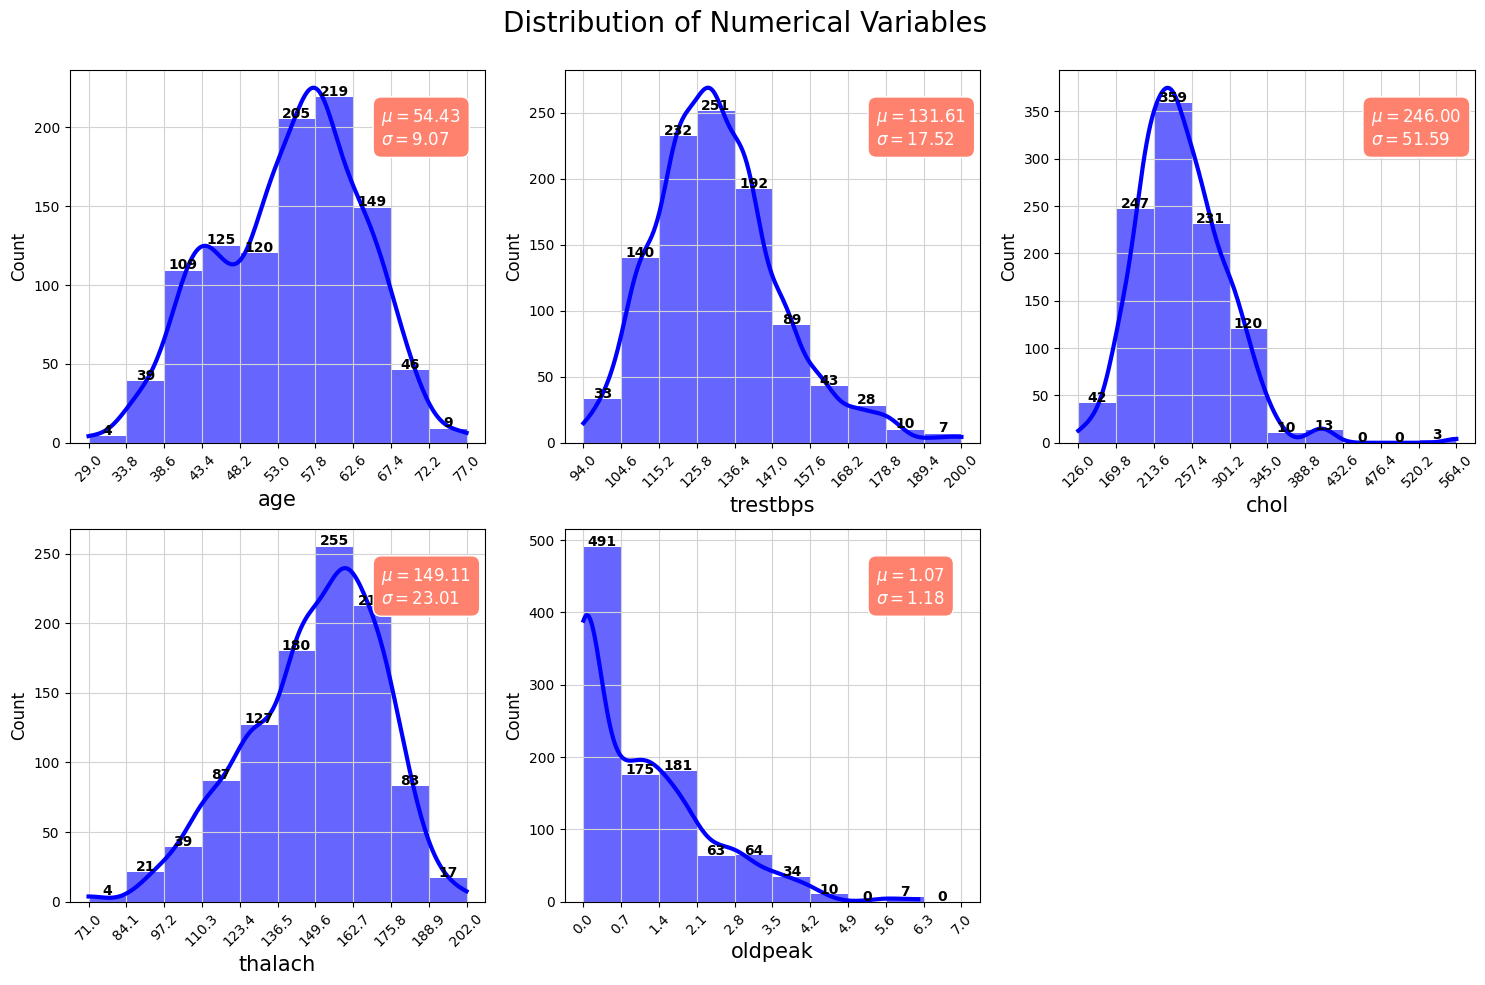

In [11]:
# Filter out continuous features for the univariate analysis
df_continuous = heart_df[numerical_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], 
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='blue', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

### Inferences:

#### Age (age):
- The distribution is somewhat uniform, but there's a peak around the late 50s.
- The mean age is approximately 54.43 years with a standard deviation of 9.08 years.

#### Resting Blood Pressure (trestbps):
- The resting blood pressure for most individuals is concentrated around 120-145 mm Hg.
- The mean resting blood pressure is approximately 131.61 mm Hg with a standard deviation of 17.52 mm Hg.

#### Serum Cholesterol (chol):
- Most individuals have cholesterol levels between 200 and 300 mg/dl.
- The mean cholesterol level is around 246.00 mg/dl with a standard deviation of 51.59 mg/dl.

#### Maximum Heart Rate Achieved (thalach):
- The majority of the individuals achieve a heart rate between 140 and 170 bpm during a stress test.
- The mean heart rate achieved is approximately 149.11 bpm with a standard deviation of 23.01 bpm.

#### ST Depression Induced by Exercise (oldpeak):
- Most of the values are concentrated towards 0, indicating that many individuals did not experience significant ST depression during exercise.
- The mean ST depression value is 1.07 with a standard deviation of 1.18.

#### Overall:
- Upon reviewing the histograms of the numerical features and cross-referencing them with the provided feature descriptions, everything appears consistent and within expected ranges.
- There doesn't seem to be any noticeable noise or implausible values among the numerical variables.


### Categorical Variables Univariate Analysis

In [12]:
# Filter out categorical features for the univariate analysis
categorical_features = heart_df.columns.difference(numerical_features)
df_categorical = heart_df[categorical_features]


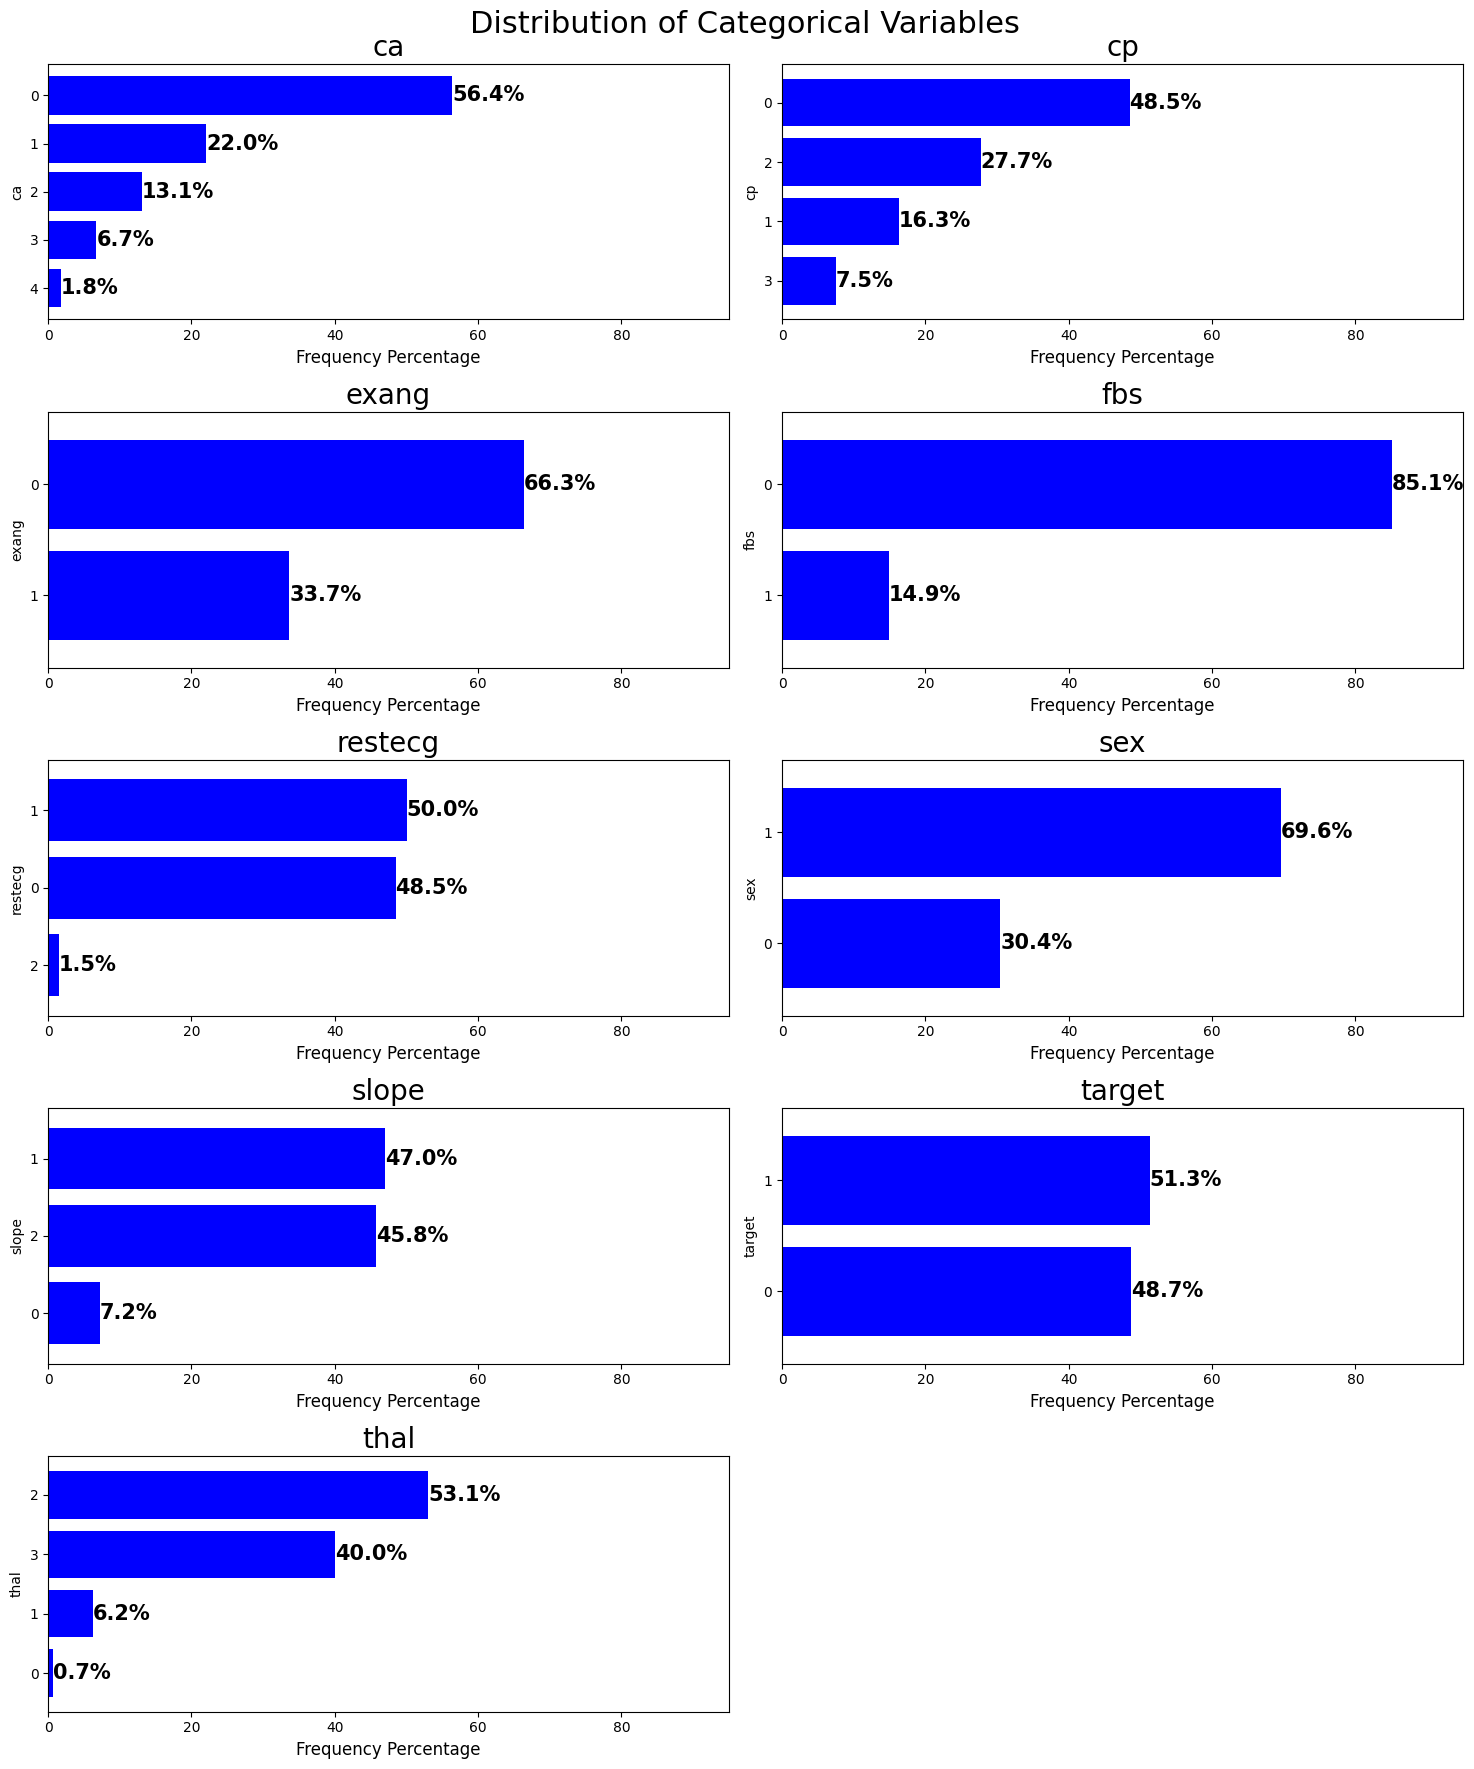

In [13]:
# Set up the subplot for a 4x2 layout
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Loop to plot bar charts for each categorical feature in the 4x2 layout
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    
    # Calculate frequency percentages
    value_counts = heart_df[col].value_counts(normalize=True).mul(100).sort_values()
    
    # Plot bar chart
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='blue')
    
    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
    
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Inferences:

#### Gender (sex):
- The dataset is predominantly female, constituting a significant majority.

#### Type of Chest Pain (cp):
- The dataset shows varied chest pain types among patients. Type 0 (Typical angina) seems to be the most prevalent, but an exact distribution among the types can be inferred from the bar plots.

#### Fasting Blood Sugar (fbs):
- A significant majority of the patients have their fasting blood sugar level below 120 mg/dl, indicating that high blood sugar is not a common condition in this dataset.

#### Resting Electrocardiographic Results (restecg):
- The results show varied resting electrocardiographic outcomes, with certain types being more common than others. The exact distribution can be gauged from the plots.

#### Exercise-Induced Angina (exang):
- A majority of the patients do not experience exercise-induced angina, suggesting that it might not be a common symptom among the patients in this dataset.

#### Slope of the Peak Exercise ST Segment (slope):
- The dataset shows different slopes of the peak exercise ST segment. A specific type might be more common, and its distribution can be inferred from the bar plots.

#### Number of Major Vessels Colored by Fluoroscopy (ca):
- Most patients have fewer major vessels colored by fluoroscopy, with '0' being the most frequent.

#### Thalium Stress Test Result (thal):
- The dataset displays a variety of thalium stress test results. One particular type seems to be more prevalent, but the exact distribution can be seen in the plots.

#### Presence of Heart Disease (target):
- The dataset is nearly balanced in terms of heart disease presence, with about 51.3% having it and 48.7% not having it.


### Biviriate Analysis

##### Numerical Features vs Target Variables

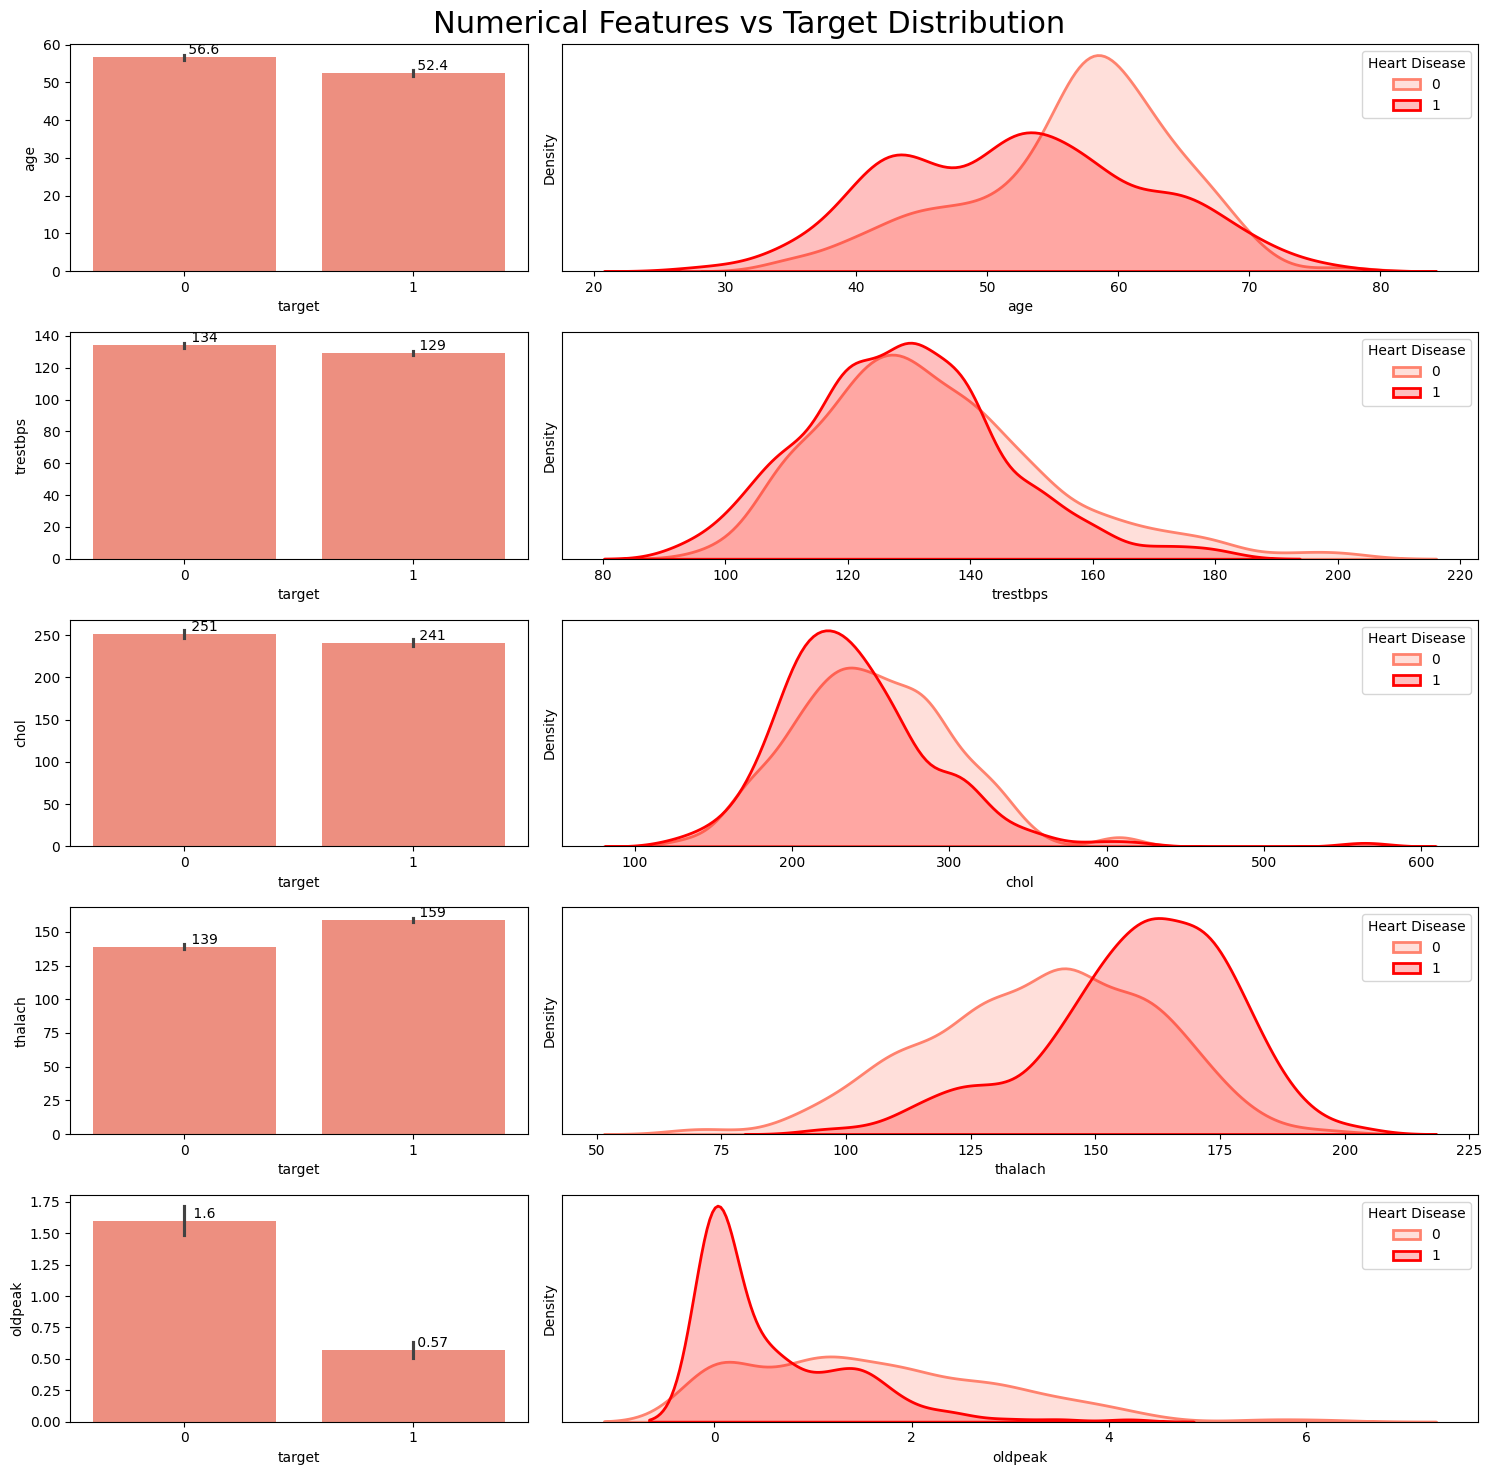

In [14]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(numerical_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(numerical_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=heart_df, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=heart_df[heart_df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=heart_df[heart_df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

### Inferences:

#### Age (age):
- The distributions show a slight shift with patients having heart disease being a bit younger on average than those without. The mean age for patients without heart disease is higher.

#### Resting Blood Pressure (trestbps):
- Both categories display overlapping distributions in the KDE plot, with nearly identical mean values, indicating limited differentiating power for this feature.

#### Serum Cholesterol (chol):
- The distributions of cholesterol levels for both categories are quite close, but the mean cholesterol level for patients with heart disease is slightly lower.

#### Maximum Heart Rate Achieved (thalach):
- There's a noticeable difference in distributions. Patients with heart disease tend to achieve a higher maximum heart rate during stress tests compared to those without.

#### ST Depression (oldpeak):
- The ST depression induced by exercise relative to rest is notably lower for patients with heart disease. Their distribution peaks near zero, whereas the non-disease category has a wider spread.


### Categorical vs Target

In [15]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']

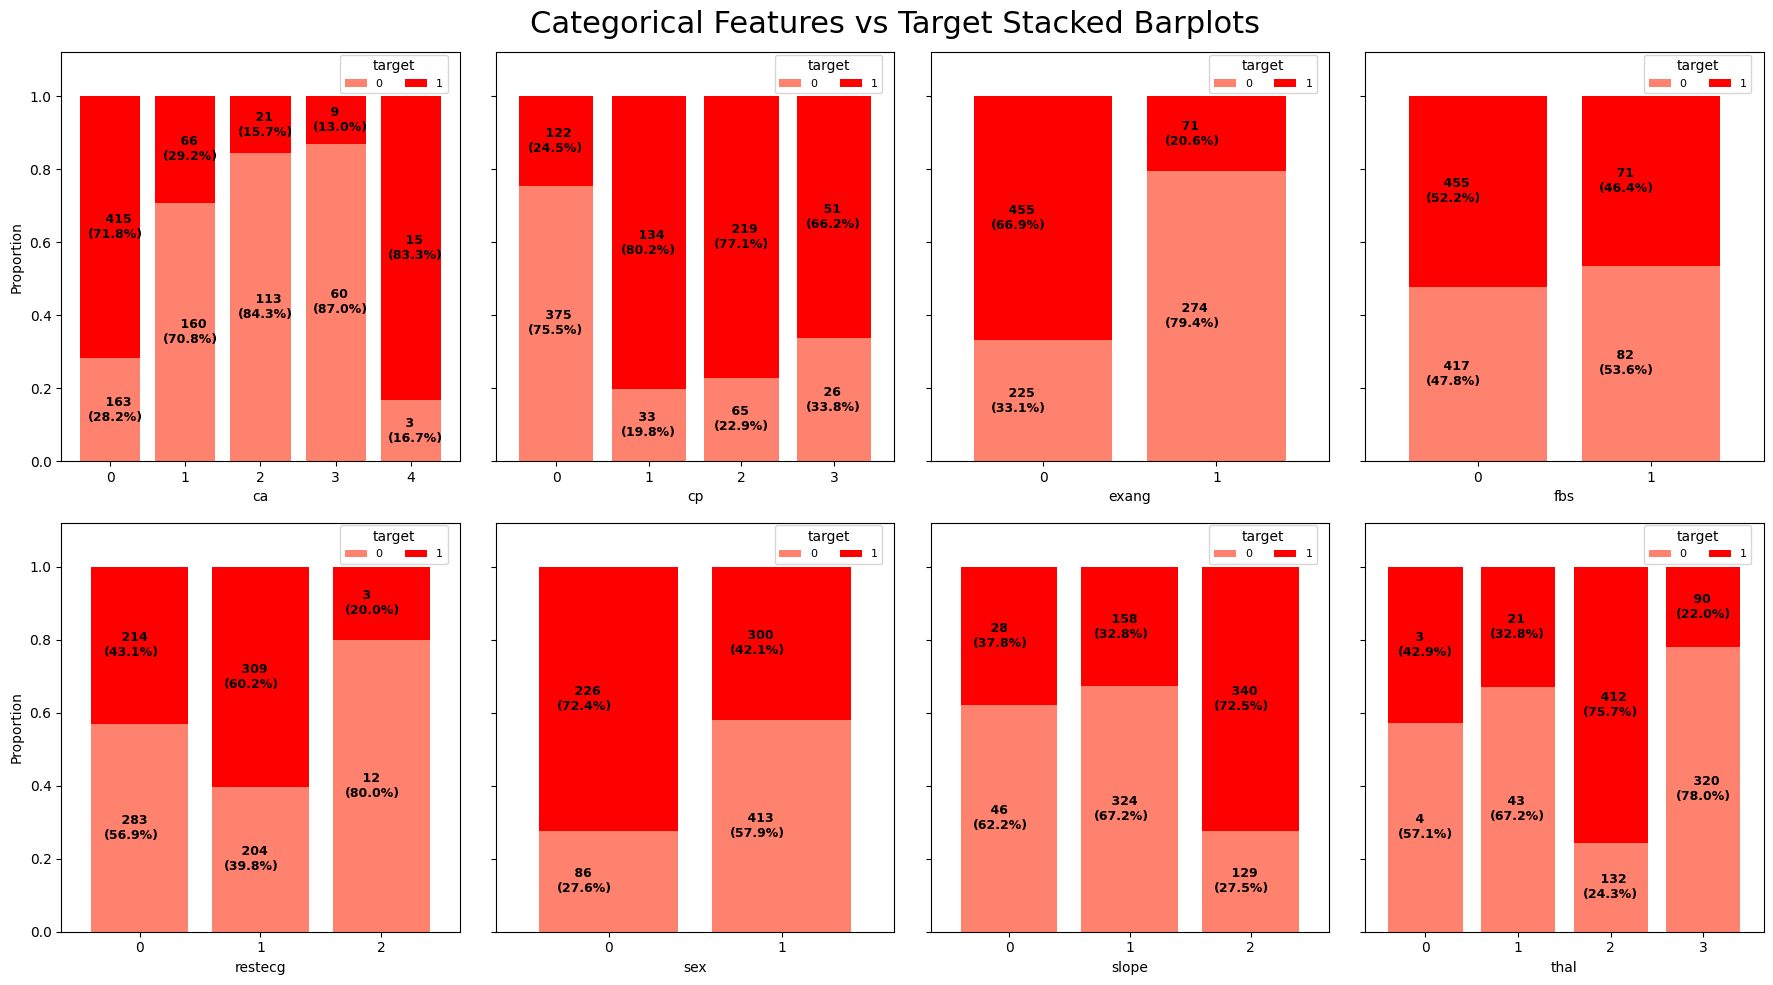

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=heart_df[col], columns=heart_df['target'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=heart_df[col], columns=heart_df['target'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

### Inferences:

#### Number of Major Vessels (ca):
- The majority of patients with heart disease have fewer major vessels colored by fluoroscopy. As the number of colored vessels increases, the proportion of patients with heart disease tends to decrease. Especially, patients with 0 vessels colored have a higher proportion of heart disease presence.

#### Chest Pain Type (cp):
- Different types of chest pain present varied proportions of heart disease. Notably, types 1, 2, and 3 have a higher proportion of heart disease presence compared to type 0. This suggests the type of chest pain can be influential in predicting the disease.

#### Exercise Induced Angina (exang):
- Patients who did not experience exercise-induced angina (0) show a higher proportion of heart disease presence compared to those who did (1). This feature seems to have a significant impact on the target.

#### Fasting Blood Sugar (fbs):
- The distribution between those with fasting blood sugar > 120 mg/dl (1) and those without (0) is relatively similar, suggesting fbs might have limited impact on heart disease prediction.

#### Resting Electrocardiographic Results (restecg):
- Type 1 displays a higher proportion of heart disease presence, indicating that this feature might have some influence on the outcome.

#### Sex (sex):
- Females (1) exhibit a lower proportion of heart disease presence compared to males (0). This indicates gender as an influential factor in predicting heart disease.

#### Slope of the Peak Exercise ST Segment (slope):
- The slope type 2 has a notably higher proportion of heart disease presence, indicating its potential as a significant predictor.

#### Thalium Stress Test Result (thal):
- The reversible defect category (2) has a higher proportion of heart disease presence compared to the other categories, emphasizing its importance in prediction.

In summary, based on the visual representation:
- **Higher Impact on Target**: ca, cp, exang, sex, slope, and thal
- **Moderate Impact on Target**: restecg
- **Lower Impact on Target**: fbs


# Data Preprocessing

### Removing outliers

In [17]:
Q1 = heart_df[numerical_features].quantile(0.25)
Q3 = heart_df[numerical_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((heart_df[numerical_features] < (Q1 - 1.5 * IQR)) | (heart_df[numerical_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age          0
trestbps    30
chol        16
thalach      4
oldpeak      7
dtype: int64

In [19]:
# Calculate Q1, Q3, and IQR
Q1 = heart_df[numerical_features].quantile(0.25)
Q3 = heart_df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier removal
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows with outliers for each numerical feature
filtered_heart_df = heart_df.copy()  # Create a copy of the original DataFrame
for feature in numerical_features:
    filtered_heart_df = filtered_heart_df[(filtered_heart_df[feature] >= lower_bound[feature]) & 
                                          (filtered_heart_df[feature] <= upper_bound[feature])]

# Check the shape of the filtered DataFrame to see how many outliers were removed
print("Original DataFrame shape:", heart_df.shape)
print("Filtered DataFrame shape:", filtered_heart_df.shape)


Original DataFrame shape: (1025, 14)
Filtered DataFrame shape: (968, 14)


#### Categorical Encoding

In [20]:
# Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(filtered_heart_df, columns=['cp', 'restecg', 'thal'], drop_first=True, dtype='int')

# Convert the rest of the categorical variables that don't need one-hot encoding to integer data type
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int32
trestbps       int64
chol           int64
fbs            int32
thalach        int64
exang          int32
oldpeak      float64
slope          int32
ca             int32
target         int32
cp_1           int32
cp_2           int32
cp_3           int32
restecg_1      int32
restecg_2      int32
thal_1         int32
thal_2         int32
thal_3         int32
dtype: object

In [21]:
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,52,1,125,212,0,168,0,1.0,2,2,0,0,0,0,1,0,0,0,1
1,53,1,140,203,1,155,1,3.1,0,0,0,0,0,0,0,0,0,0,1
2,70,1,145,174,0,125,1,2.6,0,0,0,0,0,0,1,0,0,0,1
3,61,1,148,203,0,161,0,0.0,2,1,0,0,0,0,1,0,0,0,1
4,62,0,138,294,1,106,0,1.9,1,3,0,0,0,0,1,0,0,1,0


In [22]:
# spliting dataframe into features and target
X = df_encoded.drop('target', axis=1)
y = df_encoded['target'] 

In [23]:
# spliting of data for model evaluation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model Training and Evaluation

In [24]:
# Function to tune hyperparameters
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest recall for class 1 is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [25]:
def train_model(model, X_train, y_train, model_name):
    mlflow.set_tag("model", model_name)
    
    # Train the model
    model.fit(X_train, y_train)
    
    return model

In [26]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, param_grid=None):
    mlflow.set_tag("model", model_name)
    
    # Cross validation scores
    print('Cross validation scores:')
    for metric_name, scorer in scoring_metrics.items():
        scores = cross_val_score(model, X_train, y_train, cv=6, scoring=scorer)
        print(f"{metric_name}: {scores}")
        for i, score in enumerate(scores):
            mlflow.log_metric(f"{metric_name}_fold_{i+1}", score) # Log individual fold scores
        mlflow.log_metric(f"{metric_name}_mean", scores.mean()) # Log mean score
        mlflow.log_metric(f"{metric_name}_std", scores.std())    # Log standard deviation of scores
    
    # Hyperparameter tuning
    if param_grid is not None:
        best_model, best_hyperparams = tune_clf_hyperparameters(model, param_grid, X_train, y_train)
    else:
        # no param_grid
        best_model = model
        best_hyperparams = {}
    
    # Logging best model and hyperparameters
    mlflow.log_params(best_hyperparams)
    mlflow.sklearn.log_model(best_model, f"best_{model_name}_model")
    
    # Training and testing scores
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    print(f'\nAccuracy score on train set: {train_score}')
    print(f'Accuracy score on test set: {test_score}')
    
    mlflow.log_metric("train_score", train_score)
    mlflow.log_metric("test_score", test_score)
    
    # Plotting and logging confusion matrix
    plot_and_log_confusion_matrix(best_model, X_test, y_test, model_name)
    
    return best_model, train_score, test_score


In [106]:
def plot_and_log_confusion_matrix(model, X_test, y_test, model_name, ax=None):
    # Generate confusion matrix
    cm = confusion_matrix(y_test, model.predict(X_test))

    # Plot confusion matrix
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    # Calculate metrics
    accuracy = accuracy_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))

    # Add metrics as legend
    metrics_legend = f"Acc({accuracy:.2f})\nPre({precision:.2f})\nRec({recall:.2f})\nF1({f1:.2f})"
    ax.text(0, 0, metrics_legend, horizontalalignment='left', verticalalignment='bottom',
            transform=ax.transAxes, fontsize=10, color='green')

    output_dir = "D:/RGT/Code/Heart-Disease-Prediction-Group-2/data_ai/models/confusion_matrices"
    # Ensure the directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save the plot
    plt.savefig(os.path.join(output_dir, f"{model_name}_confusion_matrix.jpg"))
    plt.show()

    # Log confusion matrix plot
    mlflow.log_artifact(os.path.join(output_dir, f"{model_name}_confusion_matrix.jpg"))
    plt.close()

In [107]:
def compare_best_models(best_models):
    """
    Parameters:
    - best_models: A dictionary containing model names as keys and tuples of training and testing scores as values.
    """
    # Extract model names, training scores, and testing scores
    model_names = list(best_models.keys())
    train_scores = [score[0] for score in best_models.values()]
    test_scores = [score[1] for score in best_models.values()]

    # Print model names along with their training and testing scores
    for model_name, train_score, test_score in zip(model_names, train_scores, test_scores):
        print(f"{model_name}: Train Score = {train_score:.4f}, Test Score = {test_score:.4f}")

    # Find the name of the best model based on the highest test score
    best_model_name = max(best_models, key=lambda x: best_models[x][1])
    best_model = best_models[best_model_name]

    # Save the best model
    if not os.path.exists('models'):
        os.makedirs('models')
    with open(f'models/{best_model_name}_model.bin', 'wb') as f_out:
        pickle.dump(best_model, f_out)
        print(f"Best model ({best_model_name}) saved to 'models/{best_model_name}_model.bin'")

    # Plot the comparison
    x = np.arange(len(model_names))
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    opacity = 0.8

    rects1 = ax.bar(x - bar_width / 2, train_scores, bar_width, alpha=opacity, color='b', label='Train Score')
    rects2 = ax.bar(x + bar_width / 2, test_scores, bar_width, alpha=opacity, color='g', label='Test Score')

    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Comparison of Best Models', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

##### Model Parameters 

In [108]:
# Parameters for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

In [109]:
# Parameters for Decision Tree 
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [110]:
# Parameters for Random Forest
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [111]:
# Parameters for K-nearest Neighbors
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30]
}

In [112]:
# Parameters for Support Vector Machines/Classifier
param_grid_svm = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

In [113]:
# Metrics for cross validation
scoring_metrics = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score)
}

In [114]:
best_models = {}

### Experiment tracking

In [115]:
# Start MLflow experiment
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("heart-disease-prediction-experiment")

<Experiment: artifact_location='file:///d:/RGT/Code/Project/Heart-Disease-Prediction-Group-2/data_ai/mlruns/1', creation_time=1714399484832, experiment_id='1', last_update_time=1714399484832, lifecycle_stage='active', name='heart-disease-prediction-experiment', tags={}>

Cross validation scores:
Accuracy: [0.8372093  0.84496124 0.89922481 0.82170543 0.82170543 0.80620155]
Precision: [0.84057971 0.85294118 0.86666667 0.82608696 0.78947368 0.828125  ]
Recall: [0.85294118 0.85294118 0.95588235 0.83823529 0.89552239 0.79104478]
F1: [0.84671533 0.85294118 0.90909091 0.83211679 0.83916084 0.80916031]

Accuracy score on train set: 0.8578811369509044
Accuracy score on test set: 0.8556701030927835


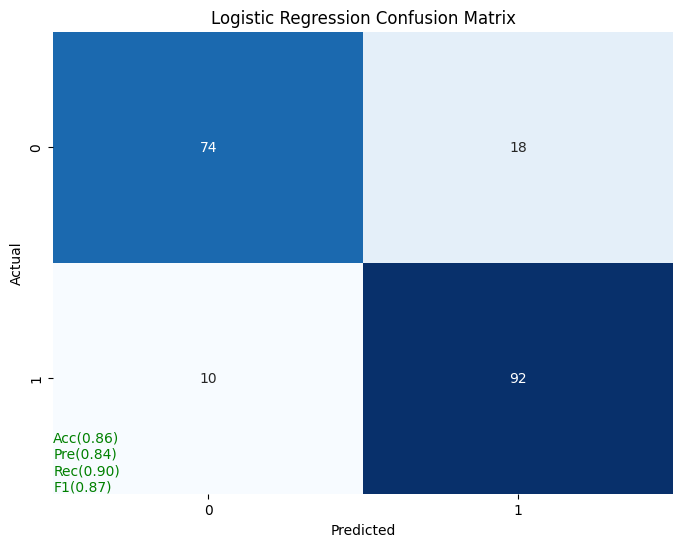

In [116]:
# Logistic Regression
with mlflow.start_run(run_name='Logistic Regression'):
    model = LogisticRegression(random_state=0)
    best_lr = train_model(model, X_train, y_train, "Logistic Regression")
    best_lr, train_score_lr, test_score_lr = evaluate_model(best_lr, X_train, X_test, y_train, y_test, "Logistic Regression", param_grid_lr)
    best_models["Logistic Regression"] = (train_score_lr, test_score_lr)


Cross validation scores:
Accuracy: [0.90697674 0.92248062 0.90697674 0.9379845  0.79844961 0.86046512]
Precision: [0.91176471 0.9375     0.93846154 0.94117647 0.82539683 0.90163934]
Recall: [0.91176471 0.91176471 0.88235294 0.94117647 0.7761194  0.82089552]
F1: [0.91176471 0.90909091 0.91729323 0.94117647 0.8        0.859375  ]

Accuracy score on train set: 0.8591731266149871
Accuracy score on test set: 0.8350515463917526


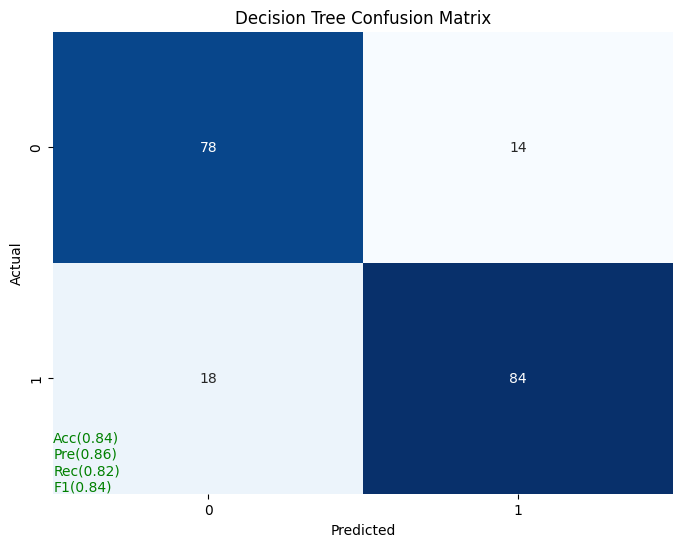

In [117]:
# Decision Tree
with mlflow.start_run(run_name="Decision Tree Classifier"):
    model = DecisionTreeClassifier(max_depth=5)
    best_dt = train_model(model, X_train, y_train, "Decision Tree")
    best_dt, train_score_dt, test_score_dt = evaluate_model(best_dt, X_train, X_test, y_train, y_test, "Decision Tree", param_grid_dt)
    best_models["Decision Tree"] = (train_score_dt, test_score_dt)

Cross validation scores:
Accuracy: [1.         0.95348837 0.98449612 0.99224806 0.99224806 0.99224806]
Precision: [1.         0.94285714 0.97142857 1.         0.98529412 0.98529412]
Recall: [1.         0.97058824 1.         0.98529412 1.         1.        ]
F1: [1.         0.95652174 0.98550725 0.99259259 0.99259259 0.99259259]

Accuracy score on train set: 0.9121447028423773
Accuracy score on test set: 0.8556701030927835


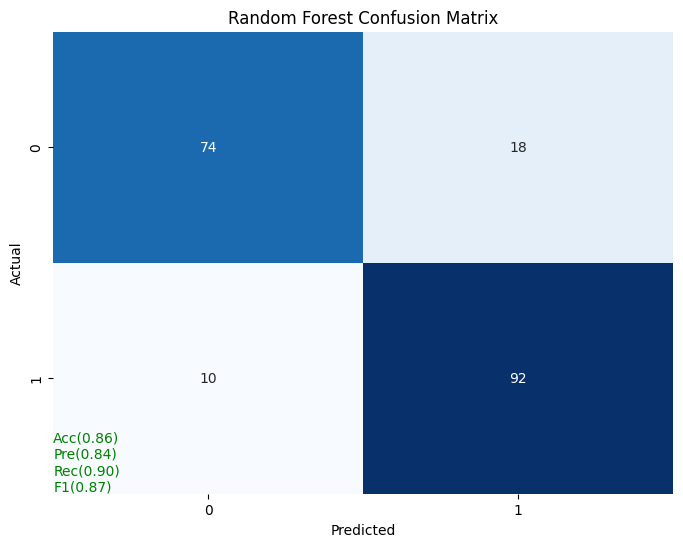

In [118]:
# Random Forest
with mlflow.start_run(run_name="Random Forest Classifier"):
    model = RandomForestClassifier(random_state=0)
    best_rf = train_model(model, X_train, y_train, "Random Forest")
    best_rf, train_score_rf, test_score_rf = evaluate_model(best_rf, X_train, X_test, y_train, y_test, "Random Forest", param_grid_rf)
    best_models["Random Forest"] = (train_score_rf, test_score_rf)

Cross validation scores:
Accuracy: [0.86821705 0.82945736 0.84496124 0.84496124 0.86821705 0.84496124]
Precision: [0.86956522 0.87096774 0.86363636 0.84285714 0.890625   0.84057971]
Recall: [0.88235294 0.79411765 0.83823529 0.86764706 0.85074627 0.86567164]
F1: [0.87591241 0.83076923 0.85074627 0.85507246 0.87022901 0.85294118]

Accuracy score on train set: 1.0
Accuracy score on test set: 0.9845360824742269


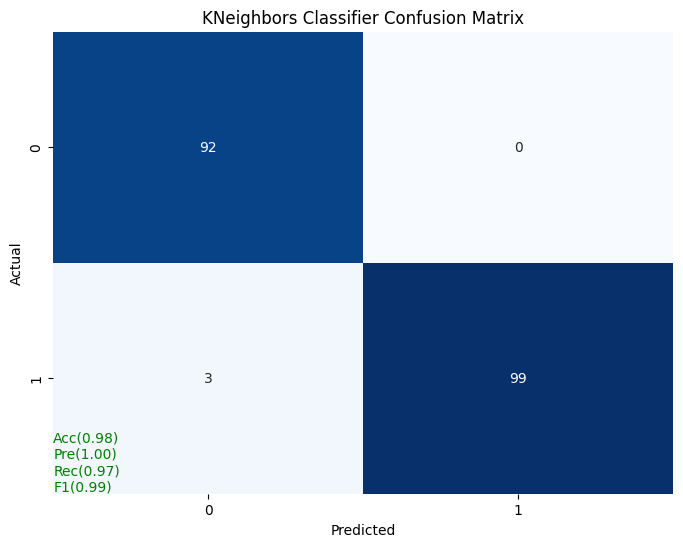

In [119]:
# KNeighborsClassifier
with mlflow.start_run(run_name='KNeighbors Classifier'):
    model = KNeighborsClassifier(n_neighbors=3)
    best_knn = train_model(model, X_train, y_train, "KNeighbors Classifier")
    best_knn, train_score_knn, test_score_knn = evaluate_model(best_knn, X_train, X_test, y_train, y_test, "KNeighbors Classifier", param_grid_knn)
    best_models["KNeighbors Classifier"] = (train_score_knn, test_score_knn)


Cross validation scores:
Accuracy: [0.87596899 0.89922481 0.91472868 0.91472868 0.87596899 0.93023256]
Precision: [0.87142857 0.88732394 0.91304348 0.88       0.86956522 0.953125  ]
Recall: [0.89705882 0.92647059 0.92647059 0.97058824 0.89552239 0.91044776]
F1: [0.88405797 0.90647482 0.91970803 0.92307692 0.88235294 0.93129771]

Accuracy score on train set: 0.9987080103359173
Accuracy score on test set: 0.9896907216494846


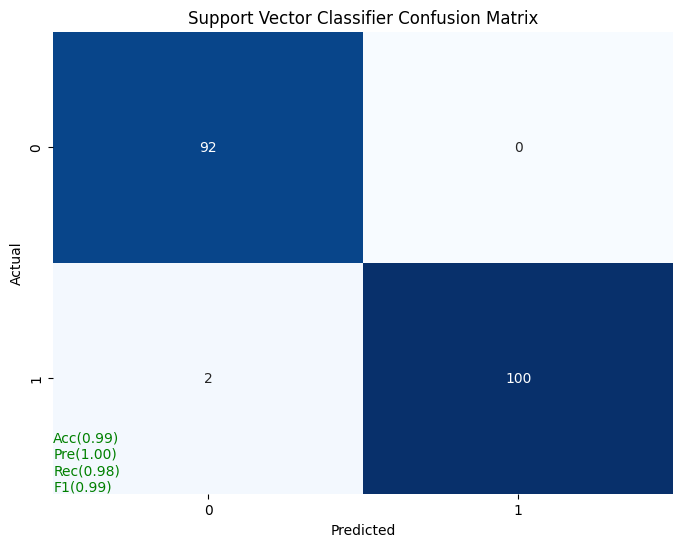

In [120]:
# Support Vector Classification
with mlflow.start_run(run_name='Support Vector Classifier'):
    model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    best_svm = train_model(model, X_train, y_train, "Support Vector Classifier")
    best_svm, train_score_svm, test_score_svm = evaluate_model(best_svm, X_train, X_test, y_train, y_test, "Support Vector Classifier", param_grid_svm)
    best_models["Support Vector Classifier"] = (train_score_svm, test_score_svm)

Logistic Regression: Train Score = 0.8579, Test Score = 0.8557
Decision Tree: Train Score = 0.8592, Test Score = 0.8351
Random Forest: Train Score = 0.9121, Test Score = 0.8557
KNeighbors Classifier: Train Score = 1.0000, Test Score = 0.9845
Support Vector Classifier: Train Score = 0.9987, Test Score = 0.9897
Best model (Support Vector Classifier) saved to 'models/Support Vector Classifier_model.bin'


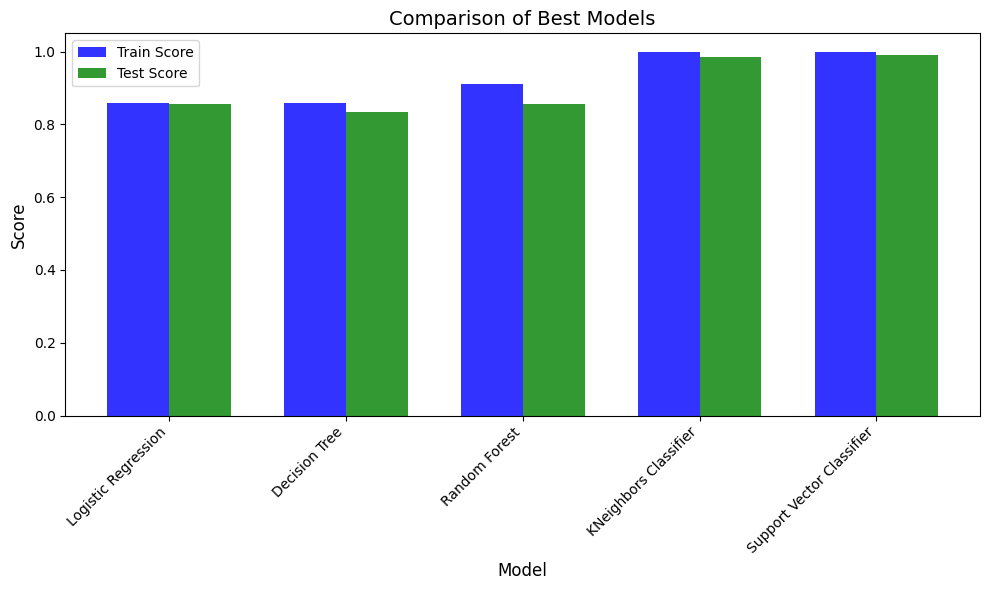

In [121]:
compare_best_models(best_models)